# RSA

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_style("whitegrid") #  {darkgrid, whitegrid, dark, white, ticks}
sns.set_context("talk")

In [2]:
def load_results(results_fn, rep_name):
    """
        Function to load the results
            - result_fn: the path to the result folder
            - rep_name: what type of representation to use (e.g, the averaged representations)
    """
    results_dir = '../results/'
    results_path = os.path.join(results_dir,results_fn)
    
    with open(results_path, 'rb') as f:
        data = pickle.load(f)
    
    # Get regression results
    analysis = data['analysis']
    t_x1, p_x1 = [], [] # 2D grid
    t_x2, p_x2 = [], [] # 1D orthogonal
    t_x3, p_x3 = [], [] # same_ctx
    for run in analysis:
        #print(run[0]['rsa'][rep_name].keys())
        t_x1.append([s['rsa'][rep_name]['t_statistic'][1] for s in run])
        t_x2.append([s['rsa'][rep_name]['t_statistic'][2] for s in run])
        t_x3.append([s['rsa'][rep_name]['t_statistic'][3] for s in run])
        p_x1.append([s['rsa'][rep_name]['p_value'][1] for s in run])
        p_x2.append([s['rsa'][rep_name]['p_value'][2] for s in run])
        p_x3.append([s['rsa'][rep_name]['p_value'][3] for s in run])
    t_x1 = np.array(t_x1)
    t_x2 = np.array(t_x2)
    t_x3 = np.array(t_x3)
    p_x1 = np.array(p_x1)
    p_x2 = np.array(p_x2)
    p_x3 = np.array(p_x3)
    
    # Get congruent vs. incongruent accuracy results
    results = data['results']
    cong_accs = []
    incong_accs = []
    for run in results:
        cong_accs.append([s['cong_acc'] for s in run['train_accs']])
        incong_accs.append([s['incong_acc'] for s in run['train_accs']])
    cong_accs = np.mean(cong_accs, axis=0)
    incong_accs = np.mean(incong_accs, axis=0)
    acc_ratios = incong_accs/cong_accs
    return t_x1, t_x2, t_x3, p_x1, p_x2, p_x3, acc_ratios

In [3]:
def plot_regression(t_x1, t_x2, t_x3, acc_ratios, title, save_fn):
    """
        Function to plot the results
            - t_x1: t_values corresponding to the 2D grid
            - t_x2: t_values corresponding to the 1D orthogonal
            - t_x3: t_values corresponding to the same_ctx
            - acc_ratios: the ration of incongruent over the congruent accuracies
            - title: title for the plot
            - save_fn: filename to save the result
    """
    color = 'tab:blue'
    n_checkpoints = len(acc_ratios)
    fig, ax = plt.subplots(3,1, sharex=True, figsize=(20,18))
    
    # 2D grid distances
    sns.boxplot(ax=ax[0], color=color, data=t_x1)
    sns.stripplot(ax=ax[0], color=color, data=t_x1)
    ax[0].axhline(y=1.96, color='r', linewidth=2)
    ax[0].axhline(y=-1.96, color='r', linewidth=2)
    ax[0].set_title('2D grid')
    ax[0].set_ylabel("T statistic")
    
    # 1D orthogonal
    sns.boxplot(ax=ax[1], color=color, data=t_x2)
    sns.stripplot(ax=ax[1], color=color, data=t_x2)
    ax[1].axhline(y=1.96, color='r', linewidth=2)
    ax[1].axhline(y=-1.96, color='r', linewidth=2)
    ax[1].set_ylabel("T statistic")
    ax[1].set_title('1D orthogonal')
    
    # Same context
    sns.boxplot(ax=ax[2], color=color, data=t_x3)
    sns.stripplot(ax=ax[2], color=color, data=t_x3)
    ax[2].axhline(y=1.96, color='r', linewidth=2)
    ax[2].axhline(y=-1.96, color='r', linewidth=2)
    ax[2].set_yscale('log')
    ax[2].set_ylabel("T statistic")
    ax[2].set_title('Same context')
    ax[2].set_xticklabels([i*analyze_every for i in range(n_checkpoints)])
    ax[2].set_xlabel("Steps")
    
    # Save
    if save_fn is not None:
        plt.savefig(save_fn, dpi=300, bbox_inches='tight')
    
    plt.show()

In [4]:
def make_tsv(model_name = 'rnn'):
    """
        Funciton to save the results as a tsv file
        - model_name: what model to use 
    """
    in_dir = '../results/' #'Path to results directory with pickle files
    out_dir = '../results/tsv/' #Path to directory to output tsv files
    # Make output directory
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    # Load basic results
    fn = os.path.join(in_dir, f"{model_name}.P")
    with open(fn, 'rb') as f:
        results = pickle.load(f)

    # RSA results (2D Euclidean, 1D Compression)
    header = []
    data = []
    analysis = results['analysis']
    for run_i, run in enumerate(analysis):
        for stat in ['betas', 't_statistic', 'p_value']:
            for var_i, var in enumerate(['int', '2D', '1D', 'ctx']):
                # Get column of data
                col = np.array([s['rsa'][rep_name][stat][var_i] for s in run])
                col = np.expand_dims(col, axis=1)
                data.append(col)

                # Header
                run_name = f"run{run_i}"
                stat_name = stat.replace('_', '-')
                head = f"{run_name}_{stat_name}_{var}"
                header.append(head)
    data = np.concatenate(data, axis=1) # [n_steps, n_runs * n_stats * n_vars]
    header = "\t".join(header) # n_runs * n_stats * n_vars
    out_file = os.path.join(out_dir, f'rsa_{model_name}.tsv')
    print(f"Writing RSA results to {out_file}")
    header_len = len(header.split('\t'))
    print(f"Shape = {data.shape}, header = {header_len}")
    np.savetxt(out_file, data, delimiter='\t', header=header)

Loading the results

In [5]:
results_fn = 'rnn.P'
rep_name = 'average'
# steps at each we do the analysis (e.g, do the analysis every 50 steps)
analyze_every = 50 
title = "RNN"
save_fn = '../figures/rsa_rnn.eps'

Loading all the results

In [6]:
t_x1, t_x2, t_x3, p_x1, p_x2, p_x3, acc_ratios = load_results(results_fn, rep_name)

Plotting the t-test results

- each dot shows one run 
- the two horizontal lines define the levels of significancy

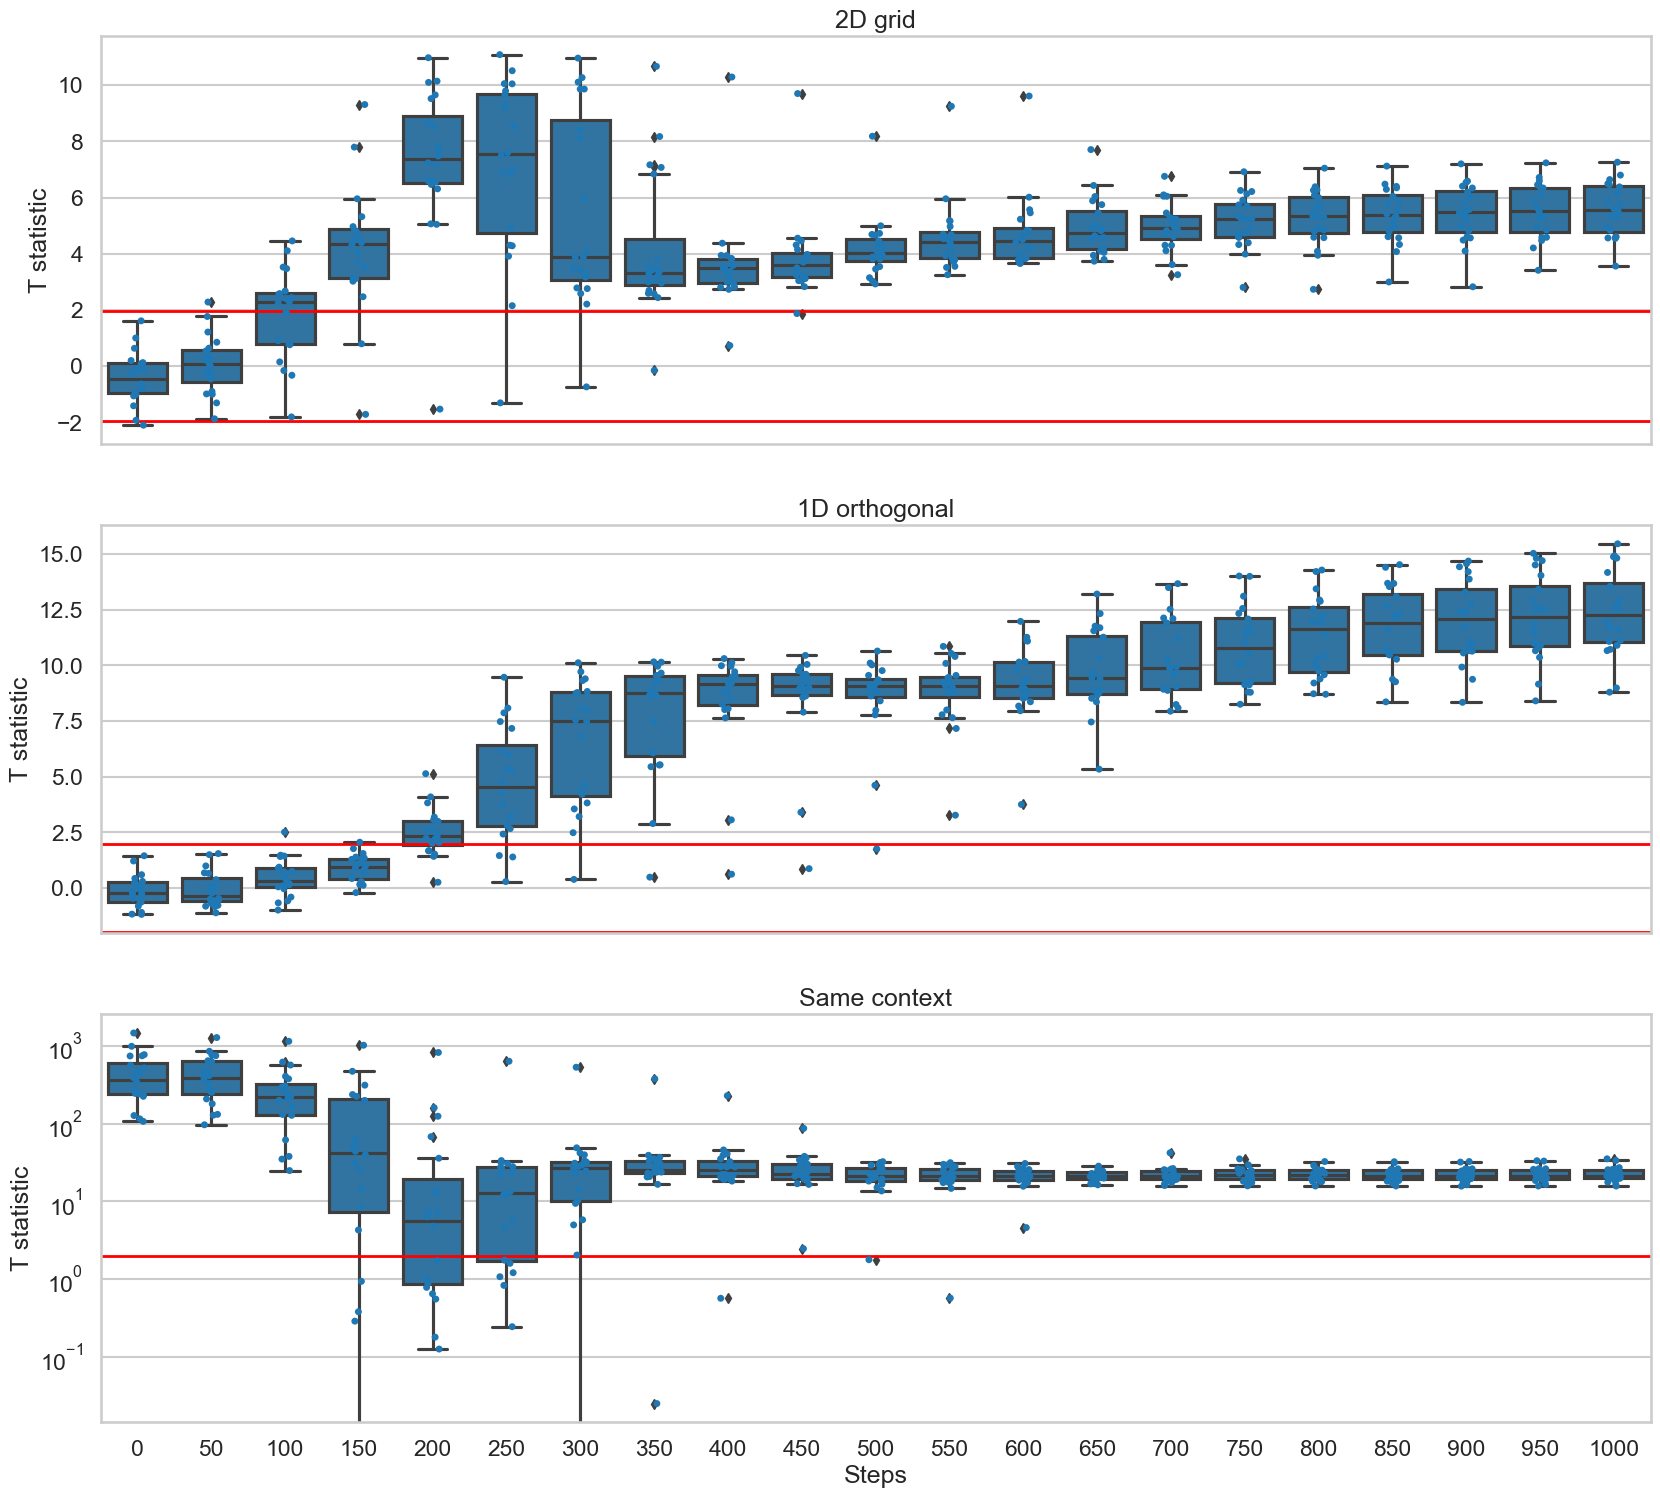

In [7]:
plot_regression(t_x1, t_x2, t_x3, acc_ratios, title, save_fn)

Get all the median t-values and p-values 

In [11]:
# Get median t-value and p-value for the first significant step for 2D grid
t_x1_median = np.median(t_x1, axis=0)
p_x1_median = np.median(p_x1, axis=0)
first_step_x1 = np.where(p_x1_median<0.001)[0][0]             
first_t_x1 = t_x1_median[first_step_x1]
first_p_x1 = p_x1_median[first_step_x1]
print("2D first:")
print("\tFirst step: ", first_step_x1*analyze_every)
print("\tFirst t: ", first_t_x1)
print("\tFirst p: ", first_p_x1)

# # Get median t-value and p-value for the first significant step for 1D orthogonal
t_x2_median = np.median(t_x2, axis=0)
p_x2_median = np.median(p_x2, axis=0)
first_step_x2 = np.where(p_x2_median<0.001)[0][0]             
first_t_x2 = t_x2_median[first_step_x2]
first_p_x2 = p_x2_median[first_step_x2]
print("1D first:")
print("\tFirst step: ", first_step_x2*analyze_every)
print("\tFirst t: ", first_t_x2)
print("\tFirst p: ", first_p_x2)


# Get median t-value and p-value for peak for 2D grid
t_x1_median = np.median(t_x1, axis=0)
p_x1_median = np.median(p_x1, axis=0)
peak_step_x1 = np.argmax(t_x1_median)
peak_t_x1 = t_x1_median[peak_step_x1]
peak_p_x1 = p_x1_median[peak_step_x1]
print("2D peak:")
print("\tPeak step: ", peak_step_x1*analyze_every)
print("\tPeak t: ", peak_t_x1)
print("\tPeak p: ", peak_p_x1)

# Get median t-value and p-value for peak for 1D orthogonal
t_x2_median = np.median(t_x2, axis=0)
p_x2_median = np.median(p_x2, axis=0)
peak_step_x2 = np.argmax(t_x2_median)
peak_t_x2 = t_x2_median[peak_step_x2]
peak_p_x2 = p_x2_median[peak_step_x2]
print("1D peak:")
print("\tPeak step: ", peak_step_x2*analyze_every)
print("\tPeak t: ", peak_t_x2)
print("\tPeak p: ", peak_p_x2)

# Get median t-value and p-value for the final significant step for 2D grid
final_t_x1 = t_x1_median[-1]
final_p_x1 = p_x1_median[-1]
print("2D final:")
print("\tFinal t: ", final_t_x1)
print("\tFinal p : ", final_p_x1)

# Get median t-value and p-value for the final significant step for 1D orthogonal 
final_t_x2 = t_x2_median[-1]
final_p_x2 = p_x2_median[-1]
print("1D final:")
print("\tFinal t: ", final_t_x2)
print("\tFinal p : ", final_p_x2)


2D first:
	First step:  150
	First t:  4.354493794824391
	First p:  1.6472417163630165e-05
1D first:
	First step:  250
	First t:  4.529477449021521
	First p:  1.1864940777935193e-05
2D peak:
	Peak step:  250
	Peak t:  7.5484290765409785
	Peak p:  2.2616690106367156e-13
1D peak:
	Peak step:  1000
	Peak t:  12.251395389717723
	Peak p:  2.6127787692705974e-29
2D final:
	Final t:  5.557338193726714
	Final p :  4.606416269806016e-08
1D final:
	Final t:  12.251395389717723
	Final p :  2.6127787692705974e-29


Save the results to a tsv file 

In [10]:
make_tsv('rnn')

Writing RSA results to ../results/tsv/rsa_rnn.tsv
Shape = (21, 240), header = 240
